# CS 8770 Project 1

## Part 1

### Load libs

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim

### Load data

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor())

In [3]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Model definitions

In [4]:
class MLP(nn.Module):
    
    # H: list of hidden layer dims
    # phi: non-linearity to use
    # n_classes: num of classes to pred
    def __init__(self, H, phi=nn.ReLU(), n_classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential()
        # create hidden layers based off input list H
        H.insert(0,28*28) # input layer
        [self.layers.append(nn.Linear(h,l)).append(phi) for h, l in zip(H,H[1:])] # hidden layers
        self.layers.append(nn.Linear(H[-1],n_classes)) # output layer

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

In [5]:
# Single RBF Neuron
class RBFNeuron(nn.Module):

    # mu: RBF mu vector
    # sig: RBF sigma
    def __init__(self, mu, sig):
        super(RBFNeuron, self).__init__()
        self.mu = mu.clone().detach()
        self.sig = sig.clone().detach()

    def __call__(self, x):
        top = torch.linalg.norm(x-self.mu, dim=1)
        return torch.exp((-0.5)*(top.pow(2) / self.sig))

# Layer of RBF Neurons
class RBFLayer(nn.Module):

    # nin: input dim
    # nout: output dim
    # mus: list of mean vectors for RBF neurons
    # sigs: list of sigmas for RBF neurons
    def __init__(self, nin, nout, mus, sigs):
        super(RBFLayer, self).__init__()
        self.neurons = nn.ModuleList([RBFNeuron(mus[i],sigs[i]) for i in range(nout)])

    def __call__(self, x):
        return torch.tensor([f(x).detach().numpy() for f in self.neurons], dtype=torch.float32, requires_grad=False).transpose(0,1)

# Full RBF Network
class RBFNet(nn.Module):

    # mus: list of means to use in basis functions
    # sigs: list of sigmas to use in basis functions
    # n_classes: num of classes to pred
    def __init__(self, mus, sigs, n_classes=10):
        super(RBFNet, self).__init__()
        self.K = len(mus) # number of RBFs
        self.mus = nn.Parameter(mus, requires_grad=False)
        self.sigs = nn.Parameter(sigs, requires_grad=False)
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            RBFLayer(28*28, self.K, self.mus, self.sigs),
            nn.Linear(self.K, n_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

In [6]:
class CNN(nn.Module):
    
    def __init__(self, n_channels, n_classes=10):
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=8,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=8, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.mlp = nn.Sequential(
            nn.Linear(7*7*64, 64),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.mlp(x)

### Train (& validation / test?) loops

In [7]:
from tqdm.notebook import tqdm # status bar

def train(model, data, loss_fn, optimizer, epochs=5):

    for epoch in range(epochs):

        epoch_loss = []

        for batch, (samples, labels) in enumerate(tqdm(data)):

            # we need to convert these into tensors
            #samples = samples.type('torch.FloatTensor')
            #labels = labels.type('torch.LongTensor')

            # forward pass
            prediction = model(samples)
            loss = loss_fn(prediction, labels)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record loss
            epoch_loss.append(loss.item())

        # keep track of loss over our batches
        #epoch_loss = statistics.mean(epoch_loss)
        print(loss)
        
def test(model, data, loss_fn):

    for batch, (samples, labels) in enumerate(tqdm(data)):

        # we need to convert these into tensors
        #samples = samples.type('torch.FloatTensor')
        #labels = labels.type('torch.LongTensor')

        # forward pass
        prediction = model(samples)
        loss = loss_fn(prediction, labels)

        # backprop
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()

    # test loss
    print(loss)

### Fit models

In [8]:
loss_fn = nn.CrossEntropyLoss()

In [9]:
# hyperparams
learning_rate = 1e-3
momentum = 0.3
epochs = 3

### MLP

In [10]:
mlp_model = MLP([128,128], nn.ReLU(), n_classes=10)

optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)

In [11]:
train(mlp_model, train_dl, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.1782, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.0685, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.0429, grad_fn=<NllLossBackward0>)


In [12]:
test(mlp_model, test_dl, loss_fn)

  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.0361, grad_fn=<NllLossBackward0>)


### RBF

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(500, init='k-means++', n_init='auto', random_state=0)
kmeans.fit(train_data.data.flatten(1))
#klabels = kmeans.predict(train_data.data.flatten(1))
clusters = kmeans.cluster_centers_.astype(float)

In [14]:
mus = torch.from_numpy(clusters)
sigs = torch.ones(len(mus))*1e-10

#mus = train_data.data.flatten(1)[:512].float() # just make mus the train data itself
#sigs = torch.ones(len(mus))*1e-3

In [15]:
rbf_model = RBFNet(mus, sigs, n_classes=10)

optimizer = optim.Adam(rbf_model.parameters(), lr=learning_rate)

In [16]:
train(rbf_model, train_dl, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

/var/folders/nl/b0l1g5b56h54lzcs1jywtm4h0000gn/T/ipykernel_99990/2447420706.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.tensor([f(x).detach().numpy() for f in self.neurons], dtype=torch.float32, requires_grad=False).transpose(0,1)


tensor(2.2951, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(2.3099, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(2.3118, grad_fn=<NllLossBackward0>)


### CNN

In [17]:
cnn_model = CNN(1, n_classes=10)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [18]:
train(cnn_model, train_dl, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.1513, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.1405, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.1899, grad_fn=<NllLossBackward0>)


In [19]:
test(cnn_model, test_dl, loss_fn)

  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.0457, grad_fn=<NllLossBackward0>)


### Results

  0%|          | 0/10000 [00:00<?, ?it/s]

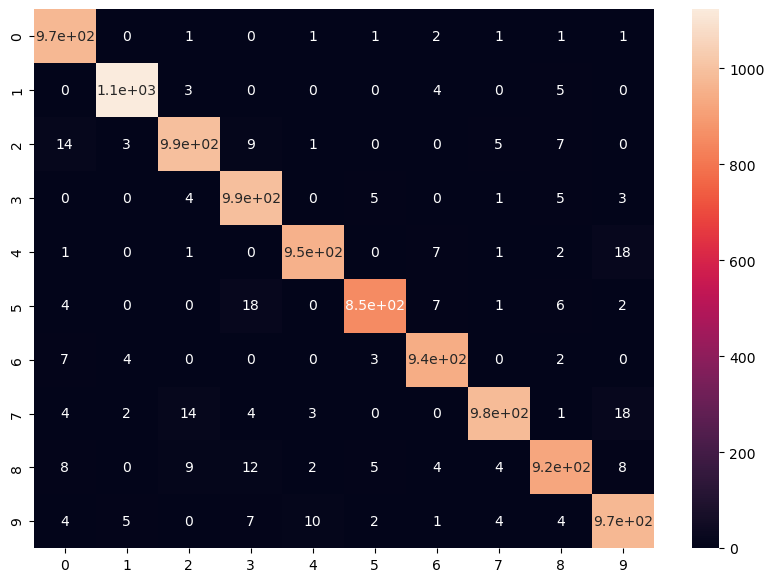

In [20]:
import seaborn as sn
import pandas as pd

# resub because we are loading our MNIST training data set
test_dl_2 = DataLoader(dataset=test_data, shuffle=True, batch_size=1)

model = cnn_model

confusion_mat = torch.zeros((10,10))
for sample, label in tqdm(test_dl_2):
    
    label = int(label.numpy())

    prediction = model(sample)
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).numpy())
    
    confusion_mat[label,prediction] += 1
    
df_cm = pd.DataFrame(np.asarray(confusion_mat), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()